# Get started with Flower

Welcome to the Flower federated learning tutorial!

In this notebook, we'll build a federated learning system using Flower, [Flower Datasets](https://flower.ai/docs/datasets/) and PyTorch. In part 1, we use PyTorch for the model training pipeline and data loading.

Let's get started!

## Step 0: Preparation

Before we begin with any actual code, let's make sure that we have everything we need.

### Installing dependencies

Next, we install the necessary packages for PyTorch (`torch` and `torchvision`), Flower Datasets (`flwr-datasets`) and Flower (`flwr`):

In [1]:
#Takes some time to download all dependencies
!pip install -qv flwr[simulation] flwr_datasets[vision] torch torchvision matplotlib

Now that we have all dependencies installed, we can import everything we need for this tutorial:

In [2]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr as fl
from flwr.common import Metrics
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import DirichletPartitioner

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)
disable_progress_bar()

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-02 13:44:53,864	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Training on cpu using PyTorch 2.3.0+cu121 and Flower 1.8.0


It is possible to switch to a runtime that has GPU acceleration enabled (on Google Colab: `Runtime > Change runtime type > Hardware accelerator: GPU > Save`). Note, however, that Google Colab is not always able to offer GPU acceleration. If you see an error related to GPU availability in one of the following sections, consider switching back to CPU-based execution by setting `DEVICE = torch.device("cpu")`. If the runtime has GPU acceleration enabled, you should see the output `Training on cuda`, otherwise it'll say `Training on cpu`.


### Loading the data

Federated learning can be applied to many different types of tasks across different domains. In this tutorial, we introduce federated learning by training a simple convolutional neural network (CNN) on the popular CIFAR-10 dataset. CIFAR-10 can be used to train image classifiers that distinguish between images from ten different classes: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', and 'truck'.

We simulate having multiple datasets from multiple organizations (also called the "cross-silo" setting in federated learning) by splitting the original CIFAR-10 dataset into multiple partitions. Each partition will represent the data from a single organization. We're doing this purely for experimentation purposes, in the real world there's no need for data splitting because each organization already has their own data (so the data is naturally partitioned).

Each organization will act as a client in the federated learning system. So having ten organizations participate in a federation means having ten clients connected to the federated learning server.



Let's now create the Federated Dataset abstraction that from `flwr-datasets` that partitions the CIFAR-10. We will create small training and test set for each edge device and wrap each of them into a PyTorch `DataLoader`:

In [3]:
#Some global variables
NUM_CLIENTS = 10
BATCH_SIZE = 32

In [5]:
def load_datasets(partitioner=None): ## <---- Provide a partitioner to this function when doing the later assignment 
    if partitioner is None:
        fds = FederatedDataset(dataset="cifar10", partitioners={"train": NUM_CLIENTS})
    else:
        fds = FederatedDataset(dataset="cifar10", partitioners={"train": partitioner})

    def apply_transforms(batch):
        # Instead of passing transforms to CIFAR10(..., transform=transform)
        # we will use this function to dataset.with_transform(apply_transforms)
        # The transforms object is exactly the same
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        batch["img"] = [transform(img) for img in batch["img"]]
        return batch

    # Create train/val for each partition and wrap it into DataLoader
    trainloaders = []
    valloaders = []
    for partition_id in range(NUM_CLIENTS):
        partition = fds.load_partition(partition_id, "train")
        partition = partition.with_transform(apply_transforms)
        partition = partition.train_test_split(train_size=0.8, seed=42)
        trainloaders.append(DataLoader(partition["train"], batch_size=BATCH_SIZE))
        valloaders.append(DataLoader(partition["test"], batch_size=BATCH_SIZE))
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(partitioner) # <--- You can pass a partitioner here

We now have a list of ten training sets and ten validation sets (`trainloaders` and `valloaders`) representing the data of ten different organizations. Each `trainloader`/`valloader` pair contains 4500 training examples and 500 validation examples. There's also a single `testloader` (we did not split the test set). Again, this is only necessary for building research or educational systems, actual federated learning systems have their data naturally distributed across multiple partitions.

Let's take a look at the first batch of images and labels in the first training set (i.e., `trainloaders[0]`) before we move on:

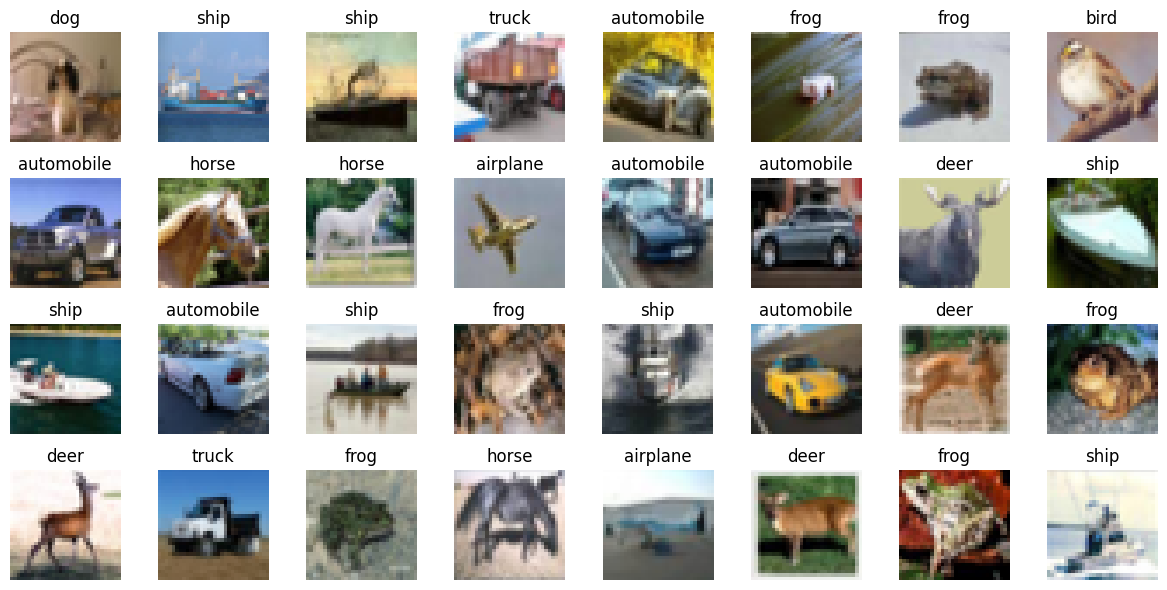

In [6]:
batch = next(iter(trainloaders[0]))
images, labels = batch["img"], batch["label"]
# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(trainloaders[0].dataset.features["label"].int2str([labels[i]])[0])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

The output above shows a random batch of images from the first `trainloader` in our list of ten `trainloaders`. It also prints the labels associated with each image (i.e., one of the ten possible labels we've seen above). If you run the cell again, you should see another batch of images.

## A quick recap: Machine Learning with PyTorch



### Classic machine learning

Before we begin to discuss federated learning, let us quickly recap how most machine learning works today.

In machine learning, we have a model, and we have data. The model could be a neural network (as depicted here), or something else, like classical linear regression.

<div style="max-width:50%; margin-left: auto; margin-right: auto;">
  <img src="https://github.com/adap/flower/blob/main/doc/source/_static/tutorial/model-and-data.png?raw=1" alt="Model and data"/>
</div>

We train the model using the data to perform a useful task. A task could be to detect objects in images, transcribe an audio recording, or play a game like Go.

<div style="max-width:50%; margin-left: auto; margin-right: auto;">
  <img src="https://github.com/adap/flower/blob/main/doc/source/_static/tutorial/train-model.png?raw=1" alt="Train model using data"/>
</div>

### Defining the model

We use the simple CNN described in the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolutional-neural-network):

In [7]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Let's continue with the usual training and test functions:

In [8]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

### Training the model

We now have all the basic building blocks we need: a dataset, a model, a training function, and a test function. Let's put them together to train the model on the dataset of one of our organizations (`trainloaders[0]`). This simulates the reality of most machine learning projects today: each organization has their own data and trains models only on this internal data:

In [9]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.05684523557552472, accuracy 0.36562203228869894
Epoch 2: validation loss 0.05160302291681737, accuracy 0.4226020892687559
Epoch 3: validation loss 0.048782929396018006, accuracy 0.45109211775878444
Epoch 4: validation loss 0.046929987067850225, accuracy 0.466286799620133
Epoch 5: validation loss 0.04583893055476581, accuracy 0.49477682811016144
Final test set performance:
	loss 0.05341994196176529
	accuracy 0.3999


Training the simple CNN on our CIFAR-10 split for 5 epochs should result in a test set accuracy of about 41%, which is not good, but at the same time, it doesn't really matter for the purposes of this tutorial. The intent was just to show a simplistic centralized training pipeline that sets the stage for what comes next - federated learning!

## Federated Learning with Flower

Now, in practice, the training data we work with doesn't originate on the machine we train the model on. It gets created somewhere else.

It originates on a smartphone by the user interacting with an app, a car collecting sensor data, a laptop receiving input via the keyboard, or a smart speaker listening to someone trying to sing a song.

<div style="max-width:30%; margin-left: auto; margin-right: auto;">
  <img src="https://github.com/adap/flower/blob/main/doc/source/_static/tutorial/data-on-phone.png?raw=1" alt="Data on a phone"/>
</div>

What's also important to mention, this "somewhere else" is usually not just one place, it's many places. It could be several devices all running the same app. But it could also be several organizations, all generating data for the same task.

<div style="max-width:30%; margin-left: auto; margin-right: auto;">
  <img src="https://github.com/adap/flower/blob/main/doc/source/_static/tutorial/many-devices-with-data.png?raw=1" alt="Data is on many devices"/>
</div>

So to use machine learning, or any kind of data analysis, the approach that has been used in the past was to collect all data on a central server. This server can be somewhere in a data center, or somewhere in the cloud.

<div style="max-width:30%; margin-left: auto; margin-right: auto;">
  <img src="https://github.com/adap/flower/blob/main/doc/source/_static/tutorial/collect-data.png?raw=1" alt="Central data collection"/>
</div>

Once all the data is collected in one place, we can finally use machine learning algorithms to train our model on the data. This is the machine learning approach that we've basically always relied on.

<div style="max-width:30%; margin-left: auto; margin-right: auto;">
  <img src="https://github.com/adap/flower/blob/main/doc/source/_static/tutorial/central-model-training.png?raw=1" alt="Central model training"/>
</div>

### Federated learning in five steps

For this practice session, we will use Flower's Virtual Client Engine to simulate distributing the models and data along a number of distributed clients. Many frameworks exist that allow the users to implement Federated Learning: Flower, FedN and Tensorflow Federated are good starting points to explore Federated Learning.

Federated learning seeks change the way machine learning is done - instead of bringing data closer to the server, send instead the models closer to the data and make models locally. Theses local models can be aggregated, so all information from all clients in the end can be utilized to generate a collaborative model. Another important use case of Federated Learning is that since data is no longer moving to the server, risks associated with privacy leaks are highly mitigated, making Federated Learning a privacy-preserving technique. 

Before we start training models under FL, we need to define the model that is going to be sent to the distributed clients.

#### Step 0: Initialize global model

We start by initializing the model on the server. This is exactly the same in classic centralized learning: we initialize the model parameters, either randomly or from a previously saved checkpoint.

<div style="max-width:25%; margin-left: auto; margin-right: auto;">
  <img src="https://github.com/adap/flower/blob/main/doc/source/_static/tutorial/fl-initialize-global-model.png?raw=1" alt="Initialize global model"/>
</div>

We're going to use the small convolutional network we defined earlier for this task:
```python
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
```

#### Step 1: Send model to a number of connected organizations/devices (client nodes)

Next, we send the parameters of the global model to the connected client nodes (think: edge devices like smartphones or servers belonging to organizations). This is to ensure that each participating node starts their local training using the same model parameters. We often use only a few of the connected nodes instead of all nodes. The reason for this is that selecting more and more client nodes has diminishing returns.

<div style="max-width:25%; margin-left: auto; margin-right: auto;">
  <img src="https://github.com/adap/flower/blob/main/doc/source/_static/tutorial/fl-send-global-model.png?raw=1" alt="Send global model"/>
</div>

### Updating model parameters

In federated learning, the server sends the global model parameters to the client, and the client updates the local model with the parameters received from the server. It then trains the model on the local data (which changes the model parameters locally) and sends the updated/changed model parameters back to the server (or, alternatively, it sends just the gradients back to the server, not the full model parameters).

We need two helper functions to update the local model with parameters received from the server and to get the updated model parameters from the local model: `set_parameters` and `get_parameters`. The following two functions do just that for the PyTorch model above.

The details of how this works are not really important here (feel free to consult the PyTorch documentation if you want to learn more). In essence, we use `state_dict` to access PyTorch model parameter tensors. The parameter tensors are then converted to/from a list of NumPy ndarray's (which Flower knows how to serialize/deserialize):

**So, in order to have the same model for all clients, we need to find a way to share weights between the server and the clients**

Let's check how the weights of the models are represented:

In [22]:
print([val.cpu().numpy() for _, val in net.state_dict().items()][0][1])

[[[-0.07334786 -0.04791215 -0.04812466  0.03603105 -0.06483676]
  [-0.10645226 -0.05574585  0.01401493  0.07092268  0.11616768]
  [ 0.09738215 -0.1388919  -0.03547632  0.03507075  0.11323044]
  [-0.03848153 -0.01310161 -0.02290785 -0.04505544 -0.04948362]
  [ 0.03072815 -0.11319376 -0.03253913  0.08314465  0.01743543]]

 [[-0.09880982  0.04101426  0.16811417  0.15808362 -0.05016248]
  [ 0.10027261 -0.0943857   0.11191048 -0.01392837 -0.01913694]
  [-0.07558443 -0.06312311 -0.0128131   0.06312085  0.08556143]
  [ 0.10654386  0.04418964  0.0918797   0.07346369  0.0042845 ]
  [ 0.01441176  0.04473873 -0.03023012  0.15301047  0.03495999]]

 [[-0.08858809 -0.09597456  0.01102117 -0.01600478 -0.07378999]
  [ 0.01256964  0.07691994 -0.04594531 -0.10799433 -0.07765809]
  [ 0.10626617 -0.15151162 -0.07975338  0.0090439   0.03243145]
  [-0.06742924 -0.04283686 -0.06244512  0.05268605 -0.00419667]
  [-0.04618991 -0.15794855  0.05098034  0.09993906 -0.10504644]]]


So, what we see here is the numeric representation of each of the weights used by the model to calculate the results.

<div style="max-width:25%; margin-left: auto; margin-right: auto;">
  <img src="https://assets.website-files.com/5ac6b7f2924c652fd013a891/5edab65ea64212da0ad611b7_5d52f096076d2b058e88cf0c_Artificial-neural-network-architecture-ANN-i-h-1-h-2-h-n-o.jpeg" alt="Train on local data"/>
</div>

This representation is transformed in a matrix, where each layer represents an entry in the array, with a  subsequent subarray is a neuron and the scalar values being the weights themselves. 

**Let's use this info to create a couple of functions to share and obtain weights**

In [10]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

### Implementing a Flower client

With that out of the way, let's move on to the interesting part. Federated learning systems consist of a server and multiple clients. In Flower, we create clients by implementing subclasses of `flwr.client.Client` or `flwr.client.NumPyClient`. We use `NumPyClient` in this tutorial because it is easier to implement and requires us to write less boilerplate.

To implement the Flower client, we create a subclass of `flwr.client.NumPyClient` and implement the three methods `get_parameters`, `fit`, and `evaluate`:

* `get_parameters`: Return the current local model parameters
* `fit`: Receive model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server
* `evaluate`: Receive model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server

We mentioned that our clients will use the previously defined PyTorch components for model training and evaluation. Let's see a simple Flower client implementation that brings everything together:

In [11]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

#### Step 2: Train model locally on the data of each organization/device (client node)

Now that all (selected) client nodes have the latest version of the global model parameters, they start the local training. They use their own local dataset to train their own local model. They don't train the model until full convergence, but they only train for a little while. This could be as little as one epoch on the local data, or even just a few steps (mini-batches).

<div style="max-width:25%; margin-left: auto; margin-right: auto;">
  <img src="https://github.com/adap/flower/blob/main/doc/source/_static/tutorial/fl-local-training.png?raw=1" alt="Train on local data"/>
</div>

Our class `FlowerClient` defines how local training/evaluation will be performed and allows Flower to call the local training/evaluation through `fit` and `evaluate`. Each instance of `FlowerClient` represents a *single client* in our federated learning system. Federated learning systems have multiple clients (otherwise, there's not much to federate), so each client will be represented by its own instance of `FlowerClient`. If we have, for example, three clients in our workload, then we'd have three instances of `FlowerClient`. Flower calls `FlowerClient.fit` on the respective instance when the server selects a particular client for training (and `FlowerClient.evaluate` for evaluation).

### Using the Virtual Client Engine

In this notebook, we want to simulate a federated learning system with 10 clients on a single machine. This means that the server and all 10 clients will live on a single machine and share resources such as CPU, GPU, and memory. Having 10 clients would mean having 10 instances of `FlowerClient` in memory. Doing this on a single machine can quickly exhaust the available memory resources, even if only a subset of these clients participates in a single round of federated learning.

In addition to the regular capabilities where server and clients run on multiple machines, Flower, therefore, provides special simulation capabilities that create `FlowerClient` instances only when they are actually necessary for training or evaluation. To enable the Flower framework to create clients when necessary, we need to implement a function called `client_fn` that creates a `FlowerClient` instance on demand. Flower calls `client_fn` whenever it needs an instance of one particular client to call `fit` or `evaluate` (those instances are usually discarded after use, so they should not keep any local state). Clients are identified by a client ID, or short `cid`. The `cid` can be used, for example, to load different local data partitions for different clients, as can be seen below:


<div style="max-width:45%; margin-left: auto; margin-right: auto;">
  <img src="./images/clientfn.png" alt="Train on local data"/>
</div>

In [12]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader).to_client()

### Starting the training

We now have the class `FlowerClient` which defines client-side training/evaluation and `client_fn` which allows Flower to create `FlowerClient` instances whenever it needs to call `fit` or `evaluate` on one particular client. The last step is to start the actual simulation using `flwr.simulation.start_simulation`.

The function `start_simulation` accepts a number of arguments, amongst them the `client_fn` used to create `FlowerClient` instances, the number of clients to simulate (`num_clients`), the number of federated learning rounds (`num_rounds`), and the strategy. The strategy encapsulates the federated learning approach/algorithm, for example, *Federated Averaging* (FedAvg).

Flower has a number of built-in strategies, but we can also use our own strategy implementations to customize nearly all aspects of the federated learning approach. For this example, we use the built-in `FedAvg` implementation and customize it using a few basic parameters. The last step is the actual call to `start_simulation` which - you guessed it - starts the simulation:

#### Step 4: Aggregate model updates into a new global model

The server receives model updates from the selected client nodes. If it selected 100 client nodes, it now has 100 slightly different versions of the original global model, each trained on the local data of one client. But didn't we want to have one model that contains the learnings from the data of all 100 client nodes?

In order to get one single model, we have to combine all the model updates we received from the client nodes. This process is called *aggregation*, and there are many different ways to do it. The most basic way to do it is called *Federated Averaging* ([McMahan et al., 2016](https://arxiv.org/abs/1602.05629)), often abbreviated as *FedAvg*. *FedAvg* takes the 100 model updates and, as the name suggests, averages them. To be more precise, it takes the *weighted average* of the model updates, weighted by the number of examples each client used for training. The weighting is important to make sure that each data example has the same "influence" on the resulting global model. If one client has 10 examples, and another client has 100 examples, then - without weighting - each of the 10 examples would influence the global model ten times as much as each of the 100 examples.

<div style="max-width:25%; margin-left: auto; margin-right: auto;">
  <img src="https://github.com/adap/flower/blob/main/doc/source/_static/tutorial/fl-aggregate-model-updates.png?raw=1" alt="Aggregate model updates"/>
</div>

In [13]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [14]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

What FedAvg is doing is applying a simple average of the weights of the models sent by the clients. The algorithm for FedAvg does the following:

<div style="max-width:25%; margin-left: auto; margin-right: auto;">
  <img src="https://www.researchgate.net/profile/Burak-Kantarci/publication/345127554/figure/fig4/AS:952936091889667@1604209077774/FedAvg-algorithm-proposed-by-McMahan-et-al-142-that-is-widely-used-as-a-standard.ppm" alt="Aggregate model updates"/>
</div>


#### Step 5: Repeat steps 2 to 4 until the model converges

Steps 1 to 4 are what we call a single round of federated learning. The global model parameters get sent to the participating client nodes (step 1), the client nodes train on their local data (step 2), they send their updated models to the server (step 3), and the server then aggregates the model updates to get a new version of the global model (step 4).

During a single round, each client node that participates in that iteration only trains for a little while. This means that after the aggregation step (step 4), we have a model that has been trained on all the data of all participating client nodes, but only for a little while. We then have to repeat this training process over and over again to eventually arrive at a fully trained model that performs well across the data of all client nodes.

In [15]:
client_resources = {"num_cpus": 1, "num_gpus": 0.0}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
2024-05-02 13:45:19,981	WARNING services.py:1832 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67104768 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.64gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-05-02 13:45:21,042	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 12.0, 'node:172.23.0.2': 1.0, 'object_store_memory': 4525898956.0, 'memory': 9051797915.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Cl

History (loss, distributed):
('\tround 1: 0.06595751589789924\n'
 '\tround 2: 0.05645654672927725\n'
 '\tround 3: 0.05330563900755875\n'
 '\tround 4: 0.050419694688302104\n'
 '\tround 5: 0.05055003006053853\n')History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.2442564693262306),
              (2, 0.3499777954936963),
              (3, 0.3537189340122994),
              (4, 0.4188872210307897),
              (5, 0.40899319975974396)]}

We now have a full system that performs federated training and federated evaluation. It uses the `weighted_average` function to aggregate custom evaluation metrics and calculates a single `accuracy` metric across all clients on the server side.

The other two categories of metrics (`losses_centralized` and `metrics_centralized`) are still empty because they only apply when centralized evaluation is being used. Part two of the Flower tutorial will cover centralized evaluation.

## Assignment

Re-run the notebook three times, but change the default partitioner to this one below. In the first run, set the alpha parameter to 0.001, but in the second run with alpha=0.5 and in the third time run with alpha=1.0. 

**What happens to the distribution of images on the datasets? Why do changing this partitioner parameter changes the training results?**

In [16]:
partitioner = DirichletPartitioner(num_partitions=10, partition_by="label",
                                   alpha=0.5, min_partition_size=10,
                                   self_balancing=True)

There are many strategies to deal with data that is not partitioned equally. Next week, we're going to discuss about one of these strategies: **Aggregation Algorithms**.

That is it for today! See you next week